In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random

import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from src.CPPN1 import CPPN1training
from sklearn.model_selection import train_test_split

In [2]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [3]:
device = 'cuda'
num_steps = 5000000
batch_size = 192
learn_rate = 0.001
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [4]:
cppn1 = CPPN1()
cppn1.load_state_dict = torch.load('Checkpoints/CPPN64.pt')
print(cppn1)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [5]:
print(len(list(cppn1.children())))

4


In [6]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

In [7]:
for name, param in cppn1.named_parameters():
    print(name)

fc1.weight
fc1.bias
fc2.weight
fc2.bias
fce1.weight
fce1.bias
fc3.weight
fc3.bias


#### Map spacial coordinates
Updated ``name.endswith`` to ``("fc3.weight"):`` so I'm only training on the last layer 

In [8]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []
layer_count = len(list(cppn1.children()))


def normalize(tensor, axis):
    if axis % 2 == 0:
        max_vals = layer_count
        min_vals = 0
    else:
        max_vals, _ = torch.max(tensor, dim=0)
        min_vals, _ = torch.min(tensor, dim=0)

    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in cppn1.named_parameters():
    
    # print(name)
    if name.endswith("fc3.weight"):
        
        # print(index)
        # print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, 3)
        temp_coords = torch.tensor(temp_coords, device=device, dtype=torch.float32)
        normal = temp_coords
        print(temp_coords)
        for i in range(4):
            # print(i)
            normal[:,i] = normalize(temp_coords[:, i], i)
            # normal = torch.nan_to_num(normal, nan = 0)
        if index == 3:
            # print(temp_coords)
            print(normal)
            # print(normal)
        full_coords.extend(normal.tolist())
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)

# print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

        

tensor([[ 3.,  0.,  4.,  0.],
        [ 3.,  1.,  4.,  0.],
        [ 3.,  2.,  4.,  0.],
        [ 3.,  3.,  4.,  0.],
        [ 3.,  4.,  4.,  0.],
        [ 3.,  5.,  4.,  0.],
        [ 3.,  6.,  4.,  0.],
        [ 3.,  7.,  4.,  0.],
        [ 3.,  8.,  4.,  0.],
        [ 3.,  9.,  4.,  0.],
        [ 3., 10.,  4.,  0.],
        [ 3., 11.,  4.,  0.],
        [ 3., 12.,  4.,  0.],
        [ 3., 13.,  4.,  0.],
        [ 3., 14.,  4.,  0.],
        [ 3., 15.,  4.,  0.],
        [ 3., 16.,  4.,  0.],
        [ 3., 17.,  4.,  0.],
        [ 3., 18.,  4.,  0.],
        [ 3., 19.,  4.,  0.],
        [ 3., 20.,  4.,  0.],
        [ 3., 21.,  4.,  0.],
        [ 3., 22.,  4.,  0.],
        [ 3., 23.,  4.,  0.],
        [ 3., 24.,  4.,  0.],
        [ 3., 25.,  4.,  0.],
        [ 3., 26.,  4.,  0.],
        [ 3., 27.,  4.,  0.],
        [ 3., 28.,  4.,  0.],
        [ 3., 29.,  4.,  0.],
        [ 3., 30.,  4.,  0.],
        [ 3., 31.,  4.,  0.],
        [ 3., 32.,  4.,  0.],
        [ 

In [9]:
# fig, ax = plt.subplots(figsize =(12,8))
# ax.scatter(range(len(full_weights)), full_weights)

#### Set up CPPN_squared

In [10]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 64)
      self.fce1 = nn.Linear(64, 64)
      self.fce2 = nn.Linear(64, 16)

      self.fc3 = nn.Linear(16, 1)     

    #   self.init_weights()
      
    # def init_weights(self):
    #   for m in self.modules():
    #       if isinstance(m, nn.Linear):
    #           # Initialize weights using Xavier initialization
    #           init.xavier_normal_(m.weight)
    #           # Initialize biases to zeros
    #           init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        # x = torch.sin(x)
        x = F.relu(x)
        # x = F.tanh(x)

        x = self.fc2(x)
        # x = torch.sin(x)
        x = F.relu(x)

        x = self.fce1(x)
        x = F.relu(x)

        x = self.fce2(x)
        x = F.relu(x)

        x = self.fc3(x)
        # x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [11]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)

criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [12]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [13]:
normalized_coords_matrix = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
# normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
# print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
# all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([ 1.1486e-01, -1.0126e-01,  1.6890e-02, -4.9757e-02,  1.0856e-01,
         9.4486e-02, -9.5382e-03,  3.2653e-02, -4.0045e-02,  2.3330e-02,
         1.5321e-03, -1.1376e-01, -1.9972e-02, -8.9038e-02,  8.5516e-02,
        -2.9499e-02, -6.9030e-02,  3.6684e-02, -7.0376e-02,  1.1722e-01,
        -7.8740e-02, -1.0975e-01, -3.2090e-02,  9.6889e-03,  8.0951e-02,
        -1.0712e-01, -1.1528e-01, -1.1934e-01, -1.1205e-01,  9.3543e-03,
         1.0810e-01, -3.3055e-02,  1.2458e-01, -7.8355e-02,  1.1398e-01,
         1.1633e-01,  4.8123e-02,  4.1446e-02, -9.1438e-02,  9.0600e-02,
         2.4988e-03,  1.1379e-01, -5.8982e-02, -6.6981e-02, -5.2856e-02,
        -1.1514e-01, -7.1593e-02,  1.2320e-01, -7.8257e-02,  7.0162e-02,
        -7.0816e-02,  8.2255e-02, -9.6099e-02, -8.9011e-02,  2.7079e-02,
        -1.2100e-01, -1.0627e-01, -8.7088e-02,  1.1338e-01,  7.3227e-02,
         4.2031e-02, -5.9034e-02, -1.1249e-01, -1.1215e-01, -1.1954e-01,
         2.6019e-02,  4.3218e-04,  3.1853e-02,  6.8

#### Split training and validation set


In [14]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
batch_size = int(batch_size * 0.9)

In [15]:
print(normalized_coords_matrix)

tensor([[ 0.5000, -1.0000,  1.0000, -1.0000],
        [ 0.5000, -0.9683,  1.0000, -1.0000],
        [ 0.5000, -0.9365,  1.0000, -1.0000],
        [ 0.5000, -0.9048,  1.0000, -1.0000],
        [ 0.5000, -0.8730,  1.0000, -1.0000],
        [ 0.5000, -0.8413,  1.0000, -1.0000],
        [ 0.5000, -0.8095,  1.0000, -1.0000],
        [ 0.5000, -0.7778,  1.0000, -1.0000],
        [ 0.5000, -0.7460,  1.0000, -1.0000],
        [ 0.5000, -0.7143,  1.0000, -1.0000],
        [ 0.5000, -0.6825,  1.0000, -1.0000],
        [ 0.5000, -0.6508,  1.0000, -1.0000],
        [ 0.5000, -0.6190,  1.0000, -1.0000],
        [ 0.5000, -0.5873,  1.0000, -1.0000],
        [ 0.5000, -0.5556,  1.0000, -1.0000],
        [ 0.5000, -0.5238,  1.0000, -1.0000],
        [ 0.5000, -0.4921,  1.0000, -1.0000],
        [ 0.5000, -0.4603,  1.0000, -1.0000],
        [ 0.5000, -0.4286,  1.0000, -1.0000],
        [ 0.5000, -0.3968,  1.0000, -1.0000],
        [ 0.5000, -0.3651,  1.0000, -1.0000],
        [ 0.5000, -0.3333,  1.0000

In [16]:
num_coords = normalized_coords_matrix.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000
display_num = 10000

for i in range(num_steps):
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, train_coords.shape[0]), batch_size)))
    
    training_coords_batch = normalized_coords_matrix[training_batch_indexes]
    
    pixel_values_batch = train_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)
    
    approx_pixel_values = CPPN_squared(training_coords_batch)
    
    loss = criterion(approx_pixel_values, pixel_values_batch)
    running_loss += loss.item()
    losses.append(loss.item())
    
    if i % display_num == 0:
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(CPPN_squared.state_dict(), 'Checkpoints/CPPN2model.pt')
        print(f'step {i}, loss {running_loss/display_num:.5f}')
        # wandb.log({"loss": loss.item()})
        running_loss = 0.0

        #validation loop
        with torch.no_grad():
            val_loss = 0.0
            val_output = CPPN_squared(val_coords)
            val_loss += criterion(val_output,val_pixel_values.unsqueeze(1)).item()

                
            print(f'Validation - Step {i}, loss {val_loss:.5f}')
            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

step 0, loss 0.000
Validation - Step 0, loss 0.013
step 10000, loss 0.003
Validation - Step 10000, loss 0.016
step 20000, loss 0.003
Validation - Step 20000, loss 0.020
step 30000, loss 0.002
Validation - Step 30000, loss 0.018
step 40000, loss 0.002
Validation - Step 40000, loss 0.040
step 50000, loss 0.002
Validation - Step 50000, loss 0.090
step 60000, loss 0.001
Validation - Step 60000, loss 0.086
step 70000, loss 0.001
Validation - Step 70000, loss 0.029
step 80000, loss 0.001
Validation - Step 80000, loss 0.019
step 90000, loss 0.001
Validation - Step 90000, loss 0.022
step 100000, loss 0.001
Validation - Step 100000, loss 0.020
step 110000, loss 0.001
Validation - Step 110000, loss 0.021
step 120000, loss 0.001
Validation - Step 120000, loss 0.020
step 130000, loss 0.001
Validation - Step 130000, loss 0.025
step 140000, loss 0.000
Validation - Step 140000, loss 0.029
step 150000, loss 0.000
Validation - Step 150000, loss 0.035
step 160000, loss 0.000
Validation - Step 160000, lo

KeyboardInterrupt: 

In [17]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction.size())

torch.Size([192])


In [18]:
print(all_pixel_values)

tensor([ 1.1486e-01, -1.0126e-01,  1.6890e-02, -4.9757e-02,  1.0856e-01,
         9.4486e-02, -9.5382e-03,  3.2653e-02, -4.0045e-02,  2.3330e-02,
         1.5321e-03, -1.1376e-01, -1.9972e-02, -8.9038e-02,  8.5516e-02,
        -2.9499e-02, -6.9030e-02,  3.6684e-02, -7.0376e-02,  1.1722e-01,
        -7.8740e-02, -1.0975e-01, -3.2090e-02,  9.6889e-03,  8.0951e-02,
        -1.0712e-01, -1.1528e-01, -1.1934e-01, -1.1205e-01,  9.3543e-03,
         1.0810e-01, -3.3055e-02,  1.2458e-01, -7.8355e-02,  1.1398e-01,
         1.1633e-01,  4.8123e-02,  4.1446e-02, -9.1438e-02,  9.0600e-02,
         2.4988e-03,  1.1379e-01, -5.8982e-02, -6.6981e-02, -5.2856e-02,
        -1.1514e-01, -7.1593e-02,  1.2320e-01, -7.8257e-02,  7.0162e-02,
        -7.0816e-02,  8.2255e-02, -9.6099e-02, -8.9011e-02,  2.7079e-02,
        -1.2100e-01, -1.0627e-01, -8.7088e-02,  1.1338e-01,  7.3227e-02,
         4.2031e-02, -5.9034e-02, -1.1249e-01, -1.1215e-01, -1.1954e-01,
         2.6019e-02,  4.3218e-04,  3.1853e-02,  6.8

Text(0.5, 1.0, 'target')

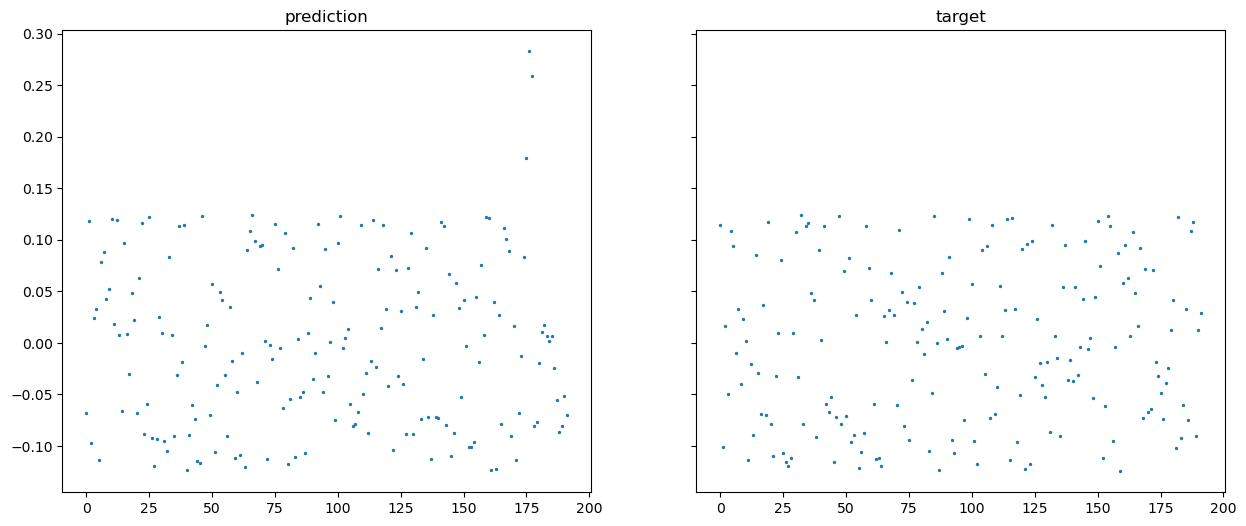

In [19]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
# ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))

ax[0].scatter(x_values, prediction.cpu().numpy(), marker='o', s=2)
ax[0].set_title("prediction")
ax[1].scatter(x_values, all_pixel_values.cpu().numpy(), marker='o', s=2)
ax[1].set_title("target")

Similarly updated ``name.endswith`` to ``("fc3.weight"):`` so I'm only replacing the last layer with new weights

In [20]:
# prediction.mul_(2).sub_(1)

index_tracker = 0
with torch.no_grad():
    for name, param in cppn1.named_parameters():
        # print(name)
        if name.endswith("fc3.weight"):
            # print(param) 
            # prediction.mul_()
            temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
            print(param.numel())
            temp_tensor = torch.reshape(temp_tensor, param.shape)
            print(temp_tensor)
            param.data.copy_(temp_tensor)
            # print(param.numel())
            index_tracker += param.numel()
    
            print(f"{name} replacement complete")

    torch.save(cppn1.state_dict(), "Checkpoints/CPPNsquared_output.pt")

192
tensor([[-0.0676,  0.1181, -0.0975,  0.0237,  0.0325, -0.1136,  0.0788,  0.0881,
          0.0425,  0.0520,  0.1205,  0.0186,  0.1189,  0.0080, -0.0657,  0.0966,
          0.0088, -0.0301,  0.0487,  0.0226, -0.0681,  0.0628,  0.1166, -0.0881,
         -0.0590,  0.1224, -0.0920, -0.1196, -0.0928,  0.0252,  0.0097, -0.0951,
         -0.1053,  0.0836,  0.0080, -0.0905, -0.0315,  0.1137, -0.0184,  0.1149,
         -0.1234, -0.0895, -0.0599, -0.0743, -0.1142, -0.1165,  0.1231, -0.0029,
          0.0177, -0.0697,  0.0572, -0.1060, -0.0406,  0.0492,  0.0422, -0.0309,
         -0.0908,  0.0344, -0.0173, -0.1117, -0.0481, -0.1085, -0.0095, -0.1201],
        [ 0.0899,  0.1082,  0.1245,  0.0991, -0.0377,  0.0941,  0.0954,  0.0022,
         -0.1123, -0.0021, -0.0152,  0.1158,  0.0719, -0.0049, -0.0627,  0.1072,
         -0.1178, -0.0542,  0.0918, -0.1103,  0.0036, -0.0528, -0.0480, -0.1065,
          0.0098,  0.0432, -0.0353, -0.0095,  0.1152,  0.0555, -0.0478,  0.0916,
         -0.0323,  0.00